In [3]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

## 0. Data load

In [4]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')

## 1. EDA

array([[<Axes: title={'center': 'strike'}>,
        <Axes: title={'center': 'lastPrice'}>,
        <Axes: title={'center': 'bid'}>, <Axes: title={'center': 'ask'}>],
       [<Axes: title={'center': 'change'}>,
        <Axes: title={'center': 'percentChange'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'openInterest'}>],
       [<Axes: title={'center': 'impliedVolatility'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'remaining'}>],
       [<Axes: title={'center': 'T'}>,
        <Axes: title={'center': 'midPrice'}>, <Axes: >, <Axes: >]],
      dtype=object)

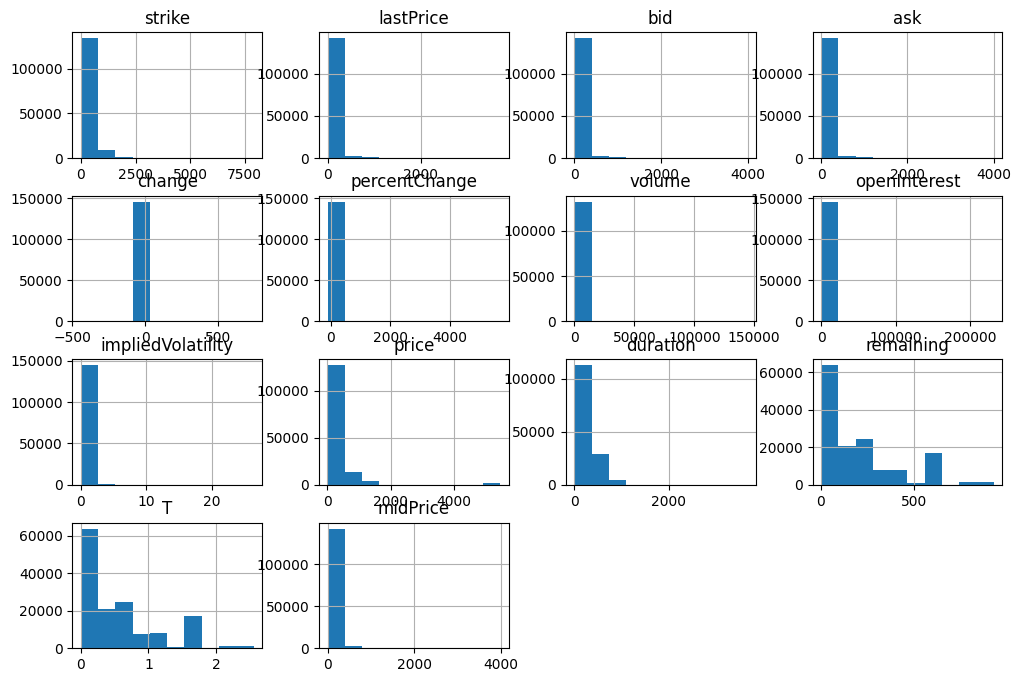

In [15]:
df.hist(figsize=(12, 8))

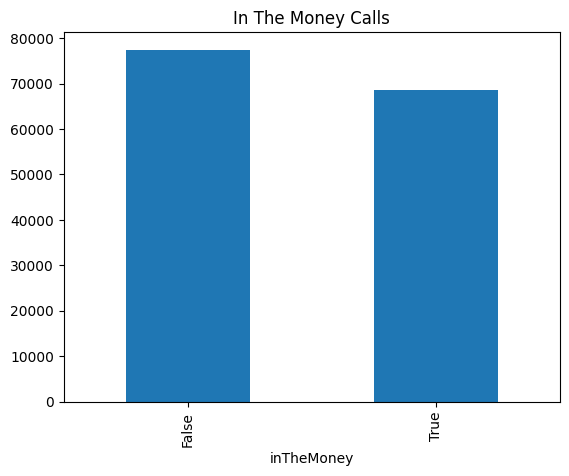

In [ ]:
df['inTheMoney'].value_counts().plot(kind='bar', title='In The Money Calls')

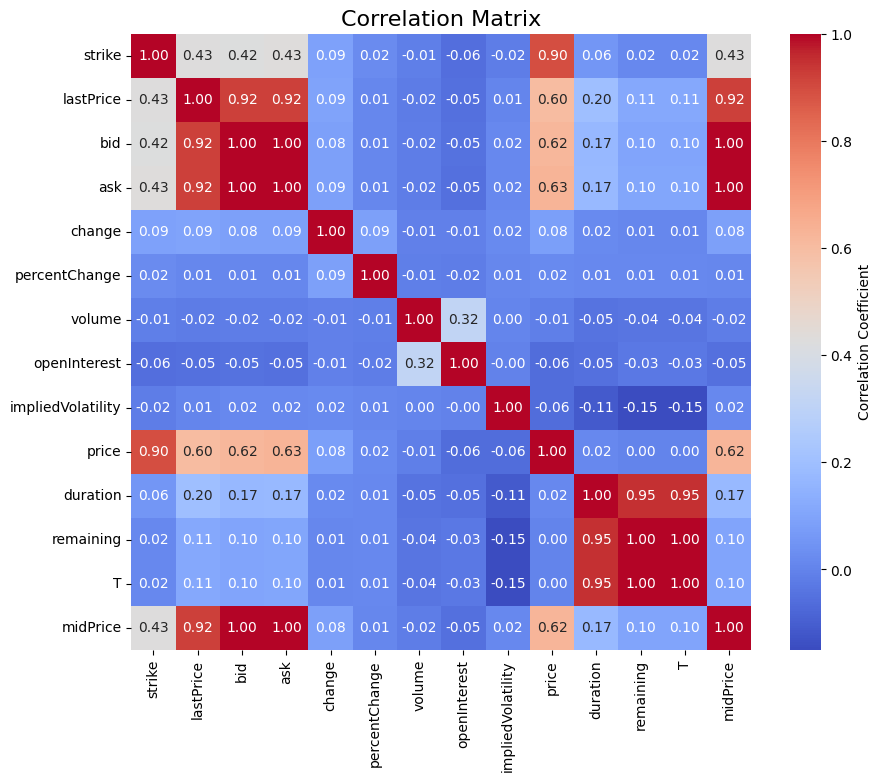

In [16]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Create a correlation matrix
corr_matrix = numeric_cols.corr()

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})

# Set the title
plt.title('Correlation Matrix', fontsize=16)

# Display the plot
plt.show()

In [20]:
columns = df.columns
# Print the columns
print("Columns in the DataFrame:")
for column in columns:
    print(column)

features = ['strike', 'price', 'remaining', 'impliedVolatility']
target = 'midPrice'

Columns in the DataFrame:
contractSymbol
lastTradeDate
strike
lastPrice
bid
ask
change
percentChange
volume
openInterest
impliedVolatility
inTheMoney
contractSize
currency
expiration
price
duration
remaining
T
midPrice


In [ ]:
df_reduced = df[features + [target]].dropna()

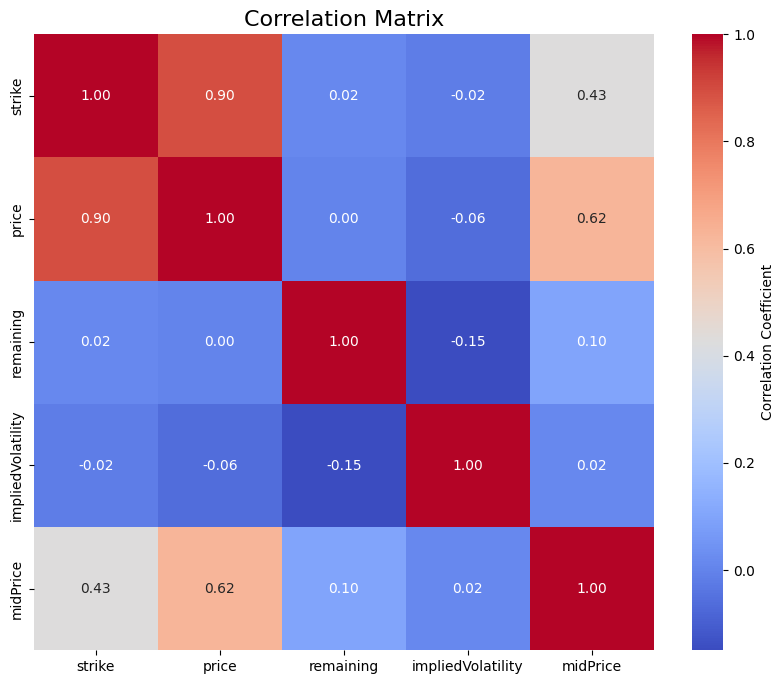

In [23]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
# Select numeric columns
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64'])

# Create a correlation matrix
corr_matrix = numeric_cols.corr()

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})

# Set the title
plt.title('Correlation Matrix', fontsize=16)

# Display the plot
plt.show()

In [36]:
INPUTS = ['strike', 'price', 'remaining', 'impliedVolatility']
OUTPUT = 'midPrice'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication
X_train.head()

,strike,price,remaining,impliedVolatility
53845,125.0,167.69,232,0.520787
101981,1790.0,134.81,204,0.000000
119036,75.0,117.34,8,1.257816
119590,1060.0,1021.30,8,0.337592
56474,270.0,156.45,8,1.649416


In [31]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

## 2. Black-Scholes model

In [73]:
def BlackScholes(S, K, T, r, sigma):
    """Calculate the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2))
    return call_price

def calculate_mid_price(row):
    S = row['price']  # Current stock price
    K = row['strike']  # Strike price
    T = row['remaining'] / 365  # Time to expiration in years
    r = 0.05  # Risk-free interest rate (assumed constant)
    sigma = row['impliedVolatility']  # Implied volatility

    return BlackScholes(S, K, T, r, sigma)

# Calculate mid price using Black-Scholes model
dfTR_eval['BS_pred'] = dfTR_eval.apply(calculate_mid_price, axis=1)
dfTS_eval['BS_pred'] = dfTS_eval.apply(calculate_mid_price, axis=1)

/var/folders/2m/mlv2fsg14t52l377d2x2_5t40000gn/T/ipykernel_53336/891631610.py:3: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/2m/mlv2fsg14t52l377d2x2_5t40000gn/T/ipykernel_53336/891631610.py:3: RuntimeWarning:

divide by zero encountered in scalar divide



In [75]:
# Calculate the error
# Entrenamiento
print('Training MAE:', mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['BS_pred']))
print('Training RMSE:', mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['BS_pred']))
print('Training R²:', r2_score(dfTR_eval['midPrice'], dfTR_eval['BS_pred']))

# Test
print('Test MAE:', mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['BS_pred']))
print('Test RMSE:', mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['BS_pred']))
print('Test R²:', r2_score(dfTS_eval['midPrice'], dfTS_eval['BS_pred']))

Training MAE: 15.339250000421147
Training RMSE: 9984.233346078736
Training R²: 0.6082743804079221
Test MAE: 15.107971998573355
Test RMSE: 8801.4356170531
Test R²: 0.6562632968634896


## 3. ML model Training

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotModelGridError(MLP_fit):
    # Extraer los resultados de la búsqueda en cuadrícula
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']  # promedio de los puntajes de validación
    params = results['params']  # combinaciones de hiperparámetros
    
    # Convertir las puntuaciones a errores (1 - score)
    errors = 1 - mean_test_scores
    
    # Crear etiquetas para cada combinación de hiperparámetros
    param_labels = [f"lr: {param['MLP__learning_rate_init']}, size: {param['MLP__hidden_layer_sizes']}" for param in params]
    
    # Ordenar los errores y etiquetas en orden decreciente
    sorted_indices = np.argsort(errors)[::-1]  # Ordenar de mayor a menor
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    
    # Crear el gráfico de error de cuadrícula
    plt.figure(figsize=(12, 6))
    plt.barh(param_labels_sorted, errors_sorted, color='skyblue')
    plt.xlabel("Error de Modelo (1 - Accuracy)")
    plt.title("Model Grid Error (Ordenado por Error Decreciente)")
    plt.gca().invert_yaxis()  # invertir el eje y para mostrar el mejor resultado en la parte superior
    plt.show()

In [40]:
INPUTS_MLP_NUM = ['strike', 'price', 'remaining', 'impliedVolatility']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ])

# param = {'MLP__learning_rate_init': [0.001, 0.01,0.1], # Initial value of learning rate 
#         'MLP__hidden_layer_sizes':[(30,),(40,),(50,),(60,),(70,)]} # Number of neurons in each hidden layer, enters as tuples
param = {'MLP__learning_rate_init': [0.001, 0.01, 0.1], # Initial value of learning rate 
        'MLP__hidden_layer_sizes':[(30,),(40,),(50,),(60,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('MLP', MLPRegressor(solver='adam', # Update function
                                activation='logistic', # Logistic sigmoid activation function
                                alpha=0.01, # L2 regularization term
                                learning_rate='adaptive', # Type of learning rate used in training
                                max_iter=250, # Maximum number of iterations
                                batch_size=10, # Size of batch when training
                                tol=1e-4, # Tolerance for the optimization
                                validation_fraction=0.0, # Percentage of samples used for validation
                                n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                random_state=150))
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP_NUM], y_train) # Search in grid

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['strike',
                                                                          'price',
                                                                          'remaining',
                                                                          'impliedVolatility'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     alpha=0.01, batch_size=10,
                                                     learning_rate='adaptive',
                                                     max_iter=250,
                                                     random_state=150,
                                                     validation_fraction=0.0))]),
             n_jobs=-1,
             param_grid={'MLP__hidden_layer_sizes': [(30,), (40,), (50,),
                                                     (60,)],
                         'MLP__learning_rate_init': [0.001, 0.01, 0.1]})

In [59]:
# Guardar el modelo
import joblib
joblib.dump(MLP_fit, '../models/MLP_fit.pkl')

['../models/MLP_fit.pkl']

In [60]:
# Cargo el modelo guardado
MLP_fit = joblib.load('../models/MLP_fit.pkl')

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plotModelGridError(MLP_fit):
    # Extraer los resultados de la búsqueda en cuadrícula
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']  # promedio de los puntajes de validación
    params = results['params']  # combinaciones de hiperparámetros
    
    # Convertir las puntuaciones a errores (1 - score)
    errors = 1 - mean_test_scores
    
    # Crear etiquetas para cada combinación de hiperparámetros
    param_labels = [f"lr: {param['MLP__learning_rate_init']}, size: {param['MLP__hidden_layer_sizes']}" for param in params]
    
    # Ordenar los errores y etiquetas en orden decreciente
    sorted_indices = np.argsort(errors)[::-1]  # Ordenar de mayor a menor
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    
    # Crear el gráfico de error de cuadrícula
    plt.figure(figsize=(12, 6))
    plt.barh(param_labels_sorted, errors_sorted, color='skyblue')
    plt.xlabel("Error de Modelo (1 - Accuracy)")
    plt.title("Model Grid Error (Ordenado por Error Decreciente)")
    plt.gca().invert_yaxis()  # invertir el eje y para mostrar el mejor resultado en la parte superior
    plt.show()

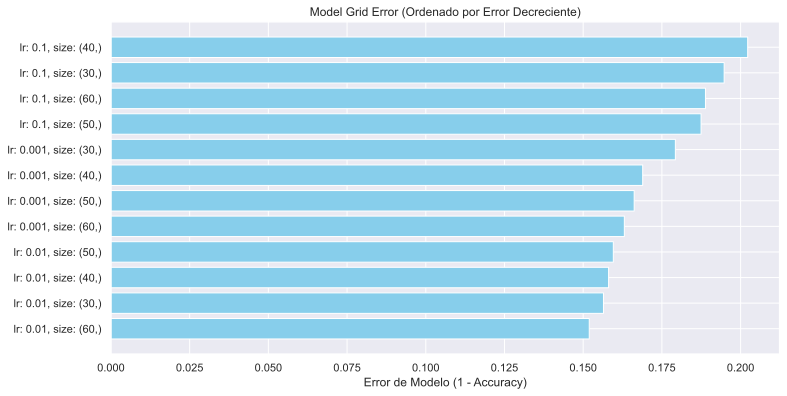

In [63]:
# Plot the cross validation score in the Grid Search
plotModelGridError(MLP_fit)

,strike,price,remaining,impliedVolatility,midPrice,MLP_pred
53845,125.0,167.69,232,0.520787,51.150,52.359128
101981,1790.0,134.81,204,0.000000,153.050,373.138990
119036,75.0,117.34,8,1.257816,42.450,23.611376
119590,1060.0,1021.30,8,0.337592,6.900,30.592491
56474,270.0,156.45,8,1.649416,0.475,1.613333
...,...,...,...,...,...,...
41993,85.0,62.45,78,0.390143,0.150,-2.283387
97639,27.5,67.21,113,1.612795,42.825,22.715421
95939,960.0,1208.55,141,0.496145,291.625,274.875038
117952,370.0,276.03,1,1.062505,0.010,2.187060


In [64]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#visualize evaluated data
dfTR_eval.head()

,strike,price,remaining,impliedVolatility,midPrice,MLP_pred
53845,125.0,167.69,232,0.520787,51.150,52.359128
101981,1790.0,134.81,204,0.000000,153.050,373.138990
119036,75.0,117.34,8,1.257816,42.450,23.611376
119590,1060.0,1021.30,8,0.337592,6.900,30.592491
56474,270.0,156.45,8,1.649416,0.475,1.613333


In [1]:

# Entrenamiento
print('Training MAE:', mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Training RMSE:', mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Training R²:', r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))

# Test
print('Test MAE:', mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
print('Test RMSE:', mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
print('Test R²:', r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

NameError: name 'mean_absolute_error' is not defined

In [79]:
exp = dx.Explainer(MLP_fit,  df[INPUTS_MLP_NUM], df[OUTPUT])

Preparation of a new explainer is initiated

  -> data              : 146088 rows 4 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 146088 values
  -> model_class       : sklearn.model_selection._search.GridSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x305725c60> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -61.5, mean = 56.8, max = 2.28e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.12e+03, mean = -1.27, max = 1.84e+03
  -> model_info        : package sklearn

A new explainer has been created!


In [81]:
prueba = X_train.loc[[1]]
prueba

,strike,price,remaining,impliedVolatility
1,115.0,148.66,1,2.111333


In [82]:
exp.predict(prueba)

array([51.86054625])

In [83]:
bd_prueba = exp.predict_parts(prueba, type='break_down', label="Prueba1")
bd_prueba.result


,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,,intercept,56.801745,56.801745,1.0,5,Prueba1
1,strike,115.0,strike = 115.0,162.223927,105.422182,1.0,4,Prueba1
2,impliedVolatility,2.111,impliedVolatility = 2.111,198.307801,36.083873,1.0,3,Prueba1
3,price,148.7,price = 148.7,46.833003,-151.474798,-1.0,2,Prueba1
4,remaining,1.0,remaining = 1.0,51.860546,5.027543,1.0,1,Prueba1
5,,,prediction,51.860546,51.860546,1.0,0,Prueba1


In [84]:
bd_prueba.plot()

In [85]:
cp_prueba = exp.predict_profile(prueba)
cp_prueba.result

Calculating ceteris paribus:   0%|          | 0/4 [00:00<?, ?it/s]/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1.    10.31  19.62  28.93  38.24  47.55  56.86  66.17  75.48  84.79
  94.1  103.41 112.72 122.03 131.34 140.65 149.96 159.27 168.58 177.89
 187.2  196.51 205.82 215.13 224.44 233.75 243.06 252.37 261.68 270.99
 280.3  289.61 298.92 308.23 317.54 326.85 336.16 345.47 354.78 364.09
 373.4  382.71 392.02 401.33 410.64 419.95 429.26 438.57 447.88 457.19
 466.5  475.81 485.12 494.43 503.74 513.05 522.36 531.67 540.98 550.29
 559.6  568.91 578.22 587.53 596.84 606.15 615.46 624.77 634.08 643.39
 652.7  662.01 671.32 680.63 689.94 699.25 708.56 717.87 727.18 736.49
 745.8  755.11 764.42 773.73 783.04 792.35 801.66 810.97 820.28 829.59
 838.9  848.21 857.52 866.83 876.14 885.45 894.76 904.07 9

,strike,price,remaining,impliedVolatility,_original_,_yhat_,_vname_,_ids_,_label_
1,0.500,148.66,1.0,2.111333,115.000000,178.586629,strike,1,GridSearchCV
1,79.495,148.66,1.0,2.111333,115.000000,80.908522,strike,1,GridSearchCV
1,115.000,148.66,1.0,2.111333,115.000000,51.860546,strike,1,GridSearchCV
1,158.490,148.66,1.0,2.111333,115.000000,37.119089,strike,1,GridSearchCV
1,237.485,148.66,1.0,2.111333,115.000000,27.722097,strike,1,GridSearchCV
...,...,...,...,...,...,...,...,...,...
1,115.000,148.66,1.0,25.357502,2.111333,777.631336,impliedVolatility,1,GridSearchCV
1,115.000,148.66,1.0,25.621642,2.111333,790.254581,impliedVolatility,1,GridSearchCV
1,115.000,148.66,1.0,25.885783,2.111333,802.934305,impliedVolatility,1,GridSearchCV
1,115.000,148.66,1.0,26.149924,2.111333,815.769312,impliedVolatility,1,GridSearchCV


In [87]:
cp_prueba.plot(variables=INPUTS_MLP_NUM)